In [1]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Selected device is {device}')

Selected device is cpu


# Hyperparameters

In [2]:
num_cells = 256
lr = 3e-4
max_grad_norm = 1.0

## Data collection parameters

In [3]:
frame_skips = 0
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000

## PPO parameters

In [4]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# Environment

In [5]:
from Environment import EnvSetup, renderEnv
from torchrl.envs import check_env_specs
from torchrl.envs.utils import RandomPolicy

In [6]:
env_setup = EnvSetup(env_name="InvertedDoublePendulum-v4", device=device)
env = env_setup.create_main_env()
test_env = env_setup.create_test_env()

In [7]:
check_env_specs(env)
check_env_specs(test_env)

2024-11-21 22:18:10,468 [torchrl][INFO] check_env_specs succeeded!


2024-11-21 22:18:10,665 [torchrl][INFO] check_env_specs succeeded!


In [8]:
renderEnv(env=test_env, max_steps=1000, policy=RandomPolicy(test_env.action_spec))

# Agent

In [9]:
from Agent import PPOAgent

In [10]:
agent = PPOAgent(
    device=device, num_cells=num_cells, env=env,
    frames_per_batch=frames_per_batch, total_frames=total_frames, 
    clip_epsilon=clip_epsilon, entropy_eps=entropy_eps, gamma=gamma,
    lmbda=lmbda, learning_rate=lr, num_epochs=num_epochs,
    sub_batch_size=sub_batch_size, max_grad_norm=max_grad_norm
)
policy_module = agent.policy_module
value_module = agent.value_module

In [11]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running v

In [12]:
agent.train()

eval cumulative reward:  82.2670 (init:  82.2670), eval step-count: 8, average reward= 9.2496 (init= 9.0836), step count (max): 51, lr policy:  0.0000: 100%|██████████| 10000/10000 [00:53<00:00, 188.68it/s]


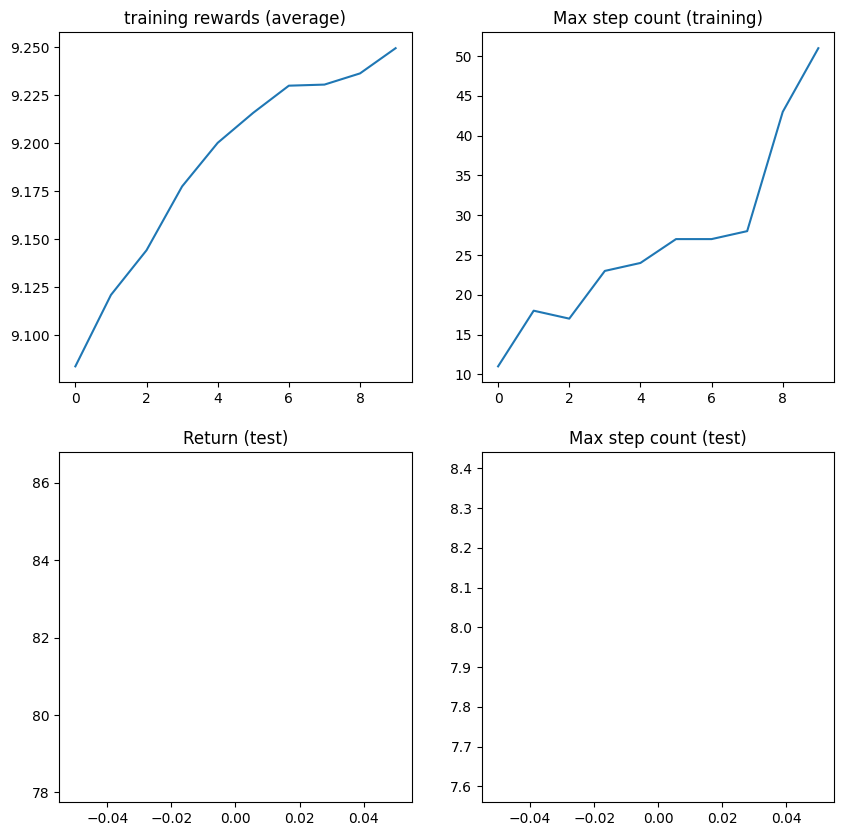

In [13]:
agent.plot_results()

In [14]:
renderEnv(env=test_env, max_steps=1000, policy=agent.policy_module)